# Predicting interest rates from Federal Reserve documents
## Model Training (Vol. 6)
FE 690: Machine Learning in Finance \\
Author: Theo Dimitrasopoulos \\
Advisor: Zachary Feinstein \\

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Use TPU
if IN_COLAB:
  # TPU Setting
  import os
  assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'  
  VERSION = "20200220"
  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
  !python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  36542      0 --:--:-- --:--:-- --:--:-- 36805
Traceback (most recent call last):
  File "pytorch-xla-env-setup.py", line 161, in <module>
    run_setup(args)
  File "pytorch-xla-env-setup.py", line 123, in run_setup
    version = get_version(args.version)
  File "pytorch-xla-env-setup.py", line 76, in get_version
    raise ValueError(f'Oldest nightly version available is {OLDEST_VERSION}')
ValueError: Oldest nightly version available is 2020-03-18 00:00:00


In [4]:
#if IN_COLAB:
#  # Uninstall existing versions:
#  !pip uninstall bs4==0.0.1 -y
#  !pip uninstall textract==1.6.3 -y
#  !pip uninstall numpy==1.19.4 -y
#  !pip uninstall pandas==1.1.4 -y
#  !pip uninstall requests==2.24.0 -y
#  !pip uninstall tqdm==4.51.0 -y
#  !pip uninstall nltk==3.5 -y
#  !pip uninstall quandl==3.5.3 -y
#  !pip uninstall scikit-plot==0.3.7 -y
#  !pip uninstall seaborn==0.11.0 -y
#  !pip uninstall sklearn==0.0 -y
#  !pip uninstall torch==1.7.0 -y
#  !pip uninstall transformers==3.5.0 -y
#  !pip uninstall wordcloud==1.8.0 -y
#  !pip uninstall xgboost==1.2.1 -y
#  
#  # Install packages:
#  !pip install bs4==0.0.1
#  !pip install textract==1.6.3
#  !pip install numpy==1.19.4
#  !pip install pandas==1.1.4
#  !pip install requests==2.24.0
#  !pip install tqdm==4.51.0
#  !pip install nltk==3.5
#  !pip install quandl==3.5.3
#  !pip install scikit-plot==0.3.7
#  !pip install seaborn==0.11.0
#  !pip install sklearn==0.0
#  !pip install torch==1.7.0
#  !pip install transformers==3.5.0
#  !pip install wordcloud==1.8.0
#  !pip install xgboost==1.2.1
#  os.kill(os.getpid(), 9)


In [5]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [7]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [8]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

## Load preprocessed data

In [9]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'

In [10]:
# Load previously processed non-text data
# Load data
file = open(train_dir + 'nontext_train_small.pickle', 'rb')
train_df = pickle.load(file)
file.close()
#train_df = pd.read_csv(train_dir + 'nontext_train_small.csv')
#print(train_df.shape)
#train_df


In [11]:
# List of Non-text columns
nontext_columns = train_df.drop(columns=['target']).columns.tolist()
nontext_columns

['prev_decision',
 'GDP_diff_prev',
 'PMI_value',
 'Employ_diff_prev',
 'Rsales_diff_year',
 'Unemp_diff_prev',
 'Inertia_diff',
 'Hsales_diff_year',
 'Balanced_diff']

In [12]:
# Load text data
file = open(preprocessed_dir + 'text_no_split.pickle', 'rb') # Original text
text_no_split = pickle.load(file)
file.close()
#text_no_split = pd.read_csv(preprocessed_dir + 'text_no_split.csv')
file = open(preprocessed_dir + 'text_split_200.pickle', 'rb') # Split at 200 words
text_split_200 = pickle.load(file)
file.close()
#text_split_200 = pd.read_csv(preprocessed_dir + 'text_split_200.csv')
file = open(preprocessed_dir + 'text_keyword.pickle', 'rb') # Paragraphs filtered for those having keywords
text_keyword = pickle.load(file)
file.close()
#text_keyword = pd.read_csv(preprocessed_dir + 'text_keyword.csv')

## Check the statistics of texts

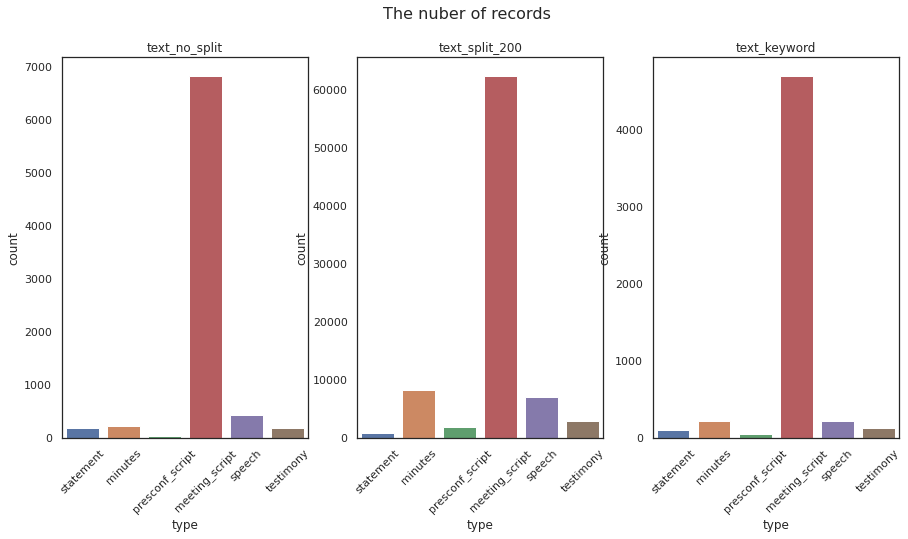

In [13]:
# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()


In [14]:
text_no_split.loc[text_no_split['type'] == 'meeting_script'].head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
463,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMA,1801,-1,9.5,1982-11-16,-1,9.0,VOLCKER.while but it may be that itsurprised m...
464,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,8439,-1,9.5,1982-11-16,-1,9.0,"Without objection, it is approved. As forthe M..."
465,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. AXILROD,567,-1,9.5,1982-11-16,-1,9.0,"Well, the one that is reserveable certainlywou..."
466,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BALLES,141,-1,9.5,1982-11-16,-1,9.0,"Well, coming at this confidence factor from al..."
467,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BLACK,415,-1,9.5,1982-11-16,-1,9.0,"Mr. Chairman, Larry rescued us from the strait..."


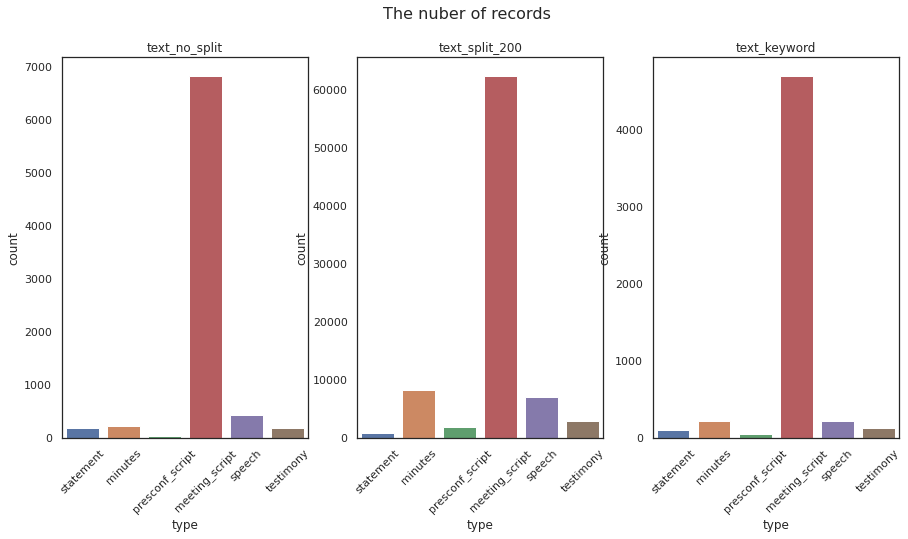

In [15]:
# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()


In [16]:
text_no_split.loc[text_no_split['type'] == 'meeting_script'].head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
463,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMA,1801,-1,9.5,1982-11-16,-1,9.0,VOLCKER.while but it may be that itsurprised m...
464,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,8439,-1,9.5,1982-11-16,-1,9.0,"Without objection, it is approved. As forthe M..."
465,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. AXILROD,567,-1,9.5,1982-11-16,-1,9.0,"Well, the one that is reserveable certainlywou..."
466,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BALLES,141,-1,9.5,1982-11-16,-1,9.0,"Well, coming at this confidence factor from al..."
467,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BLACK,415,-1,9.5,1982-11-16,-1,9.0,"Mr. Chairman, Larry rescued us from the strait..."


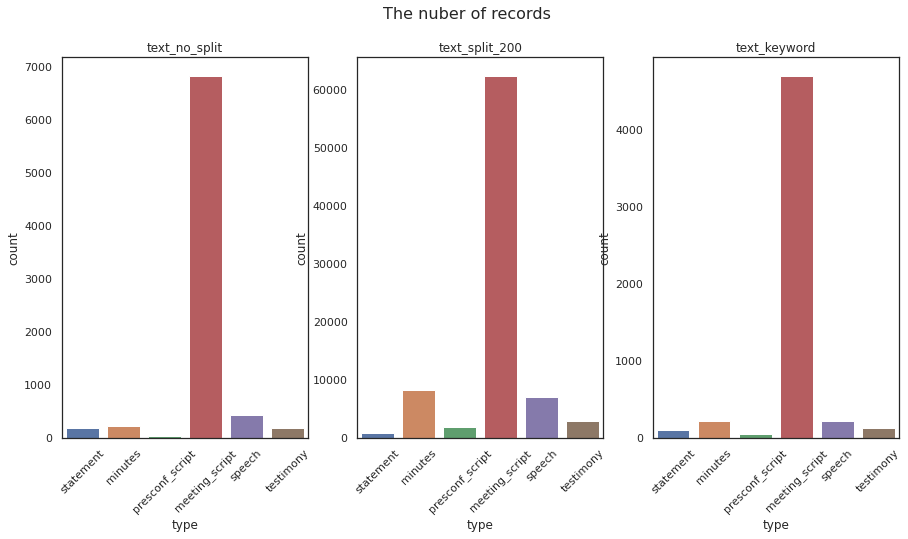

In [17]:
# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()


In [18]:
# Select one from the above different pre-processed data
text_df = text_no_split
text_df.reset_index(drop=True, inplace=True)
print(text_df.shape)
text_df

(7908, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."
...,...,...,...,...,...,...,...,...,...,...,...
7903,testimony,2020-05-19,Coronavirus and CARES Act,Jerome Powell,1802,<NA>,None,2020-06-10,0,0.00,I would like to begin by acknowledging the tra...
7904,testimony,2020-06-16,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1433,<NA>,None,2020-07-29,0,0.00,Our country continues to face a difficult and ...
7905,testimony,2020-06-30,Coronavirus and CARES Act,Jerome Powell,2759,<NA>,None,2020-07-29,0,0.00,We meet as the pandemic continues to cause tre...
7906,testimony,2020-09-22,"Coronavirus Aid, Relief, and Economic Security...",Jerome Powell,2400,<NA>,None,2020-11-05,0,NaN,"Chairwoman Waters, Ranking Member McHenry, and..."


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


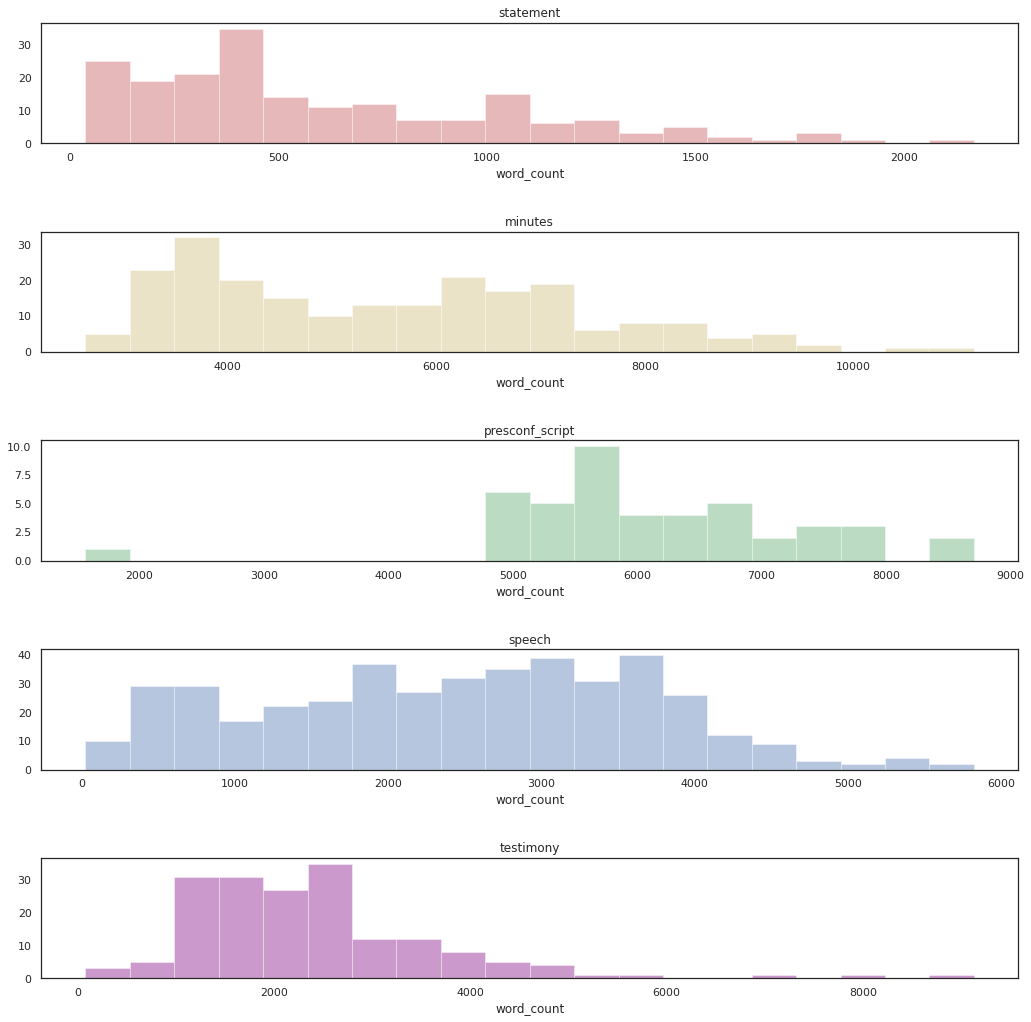

In [19]:
# Check distribution

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))
doc_type = 'statement'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=False, color='r')
ax1.set_title(doc_type)
doc_type = 'minutes'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=False, color='y')
ax2.set_title(doc_type)
doc_type = 'presconf_script'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=False, color='g')
ax3.set_title(doc_type)
doc_type = 'speech'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=False, color='b')
ax4.set_title(doc_type)
doc_type = 'testimony'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=False, color='purple')
ax5.set_title(doc_type)

fig.tight_layout(pad=3.0)
plt.show()

In [20]:
# Check balance of Rate Decision

#g = sns.FacetGrid(text_df, col='type', height=6, aspect=0.5)
#g.map(sns.countplot, 'next_decision')
#plt.show()


In [21]:
from collections import defaultdict 

doc_types = text_df['type'].unique()

merged_dict = defaultdict(list)

for i, row in train_df.iterrows():
    text_rows = text_df.loc[text_df['next_meeting'] == i]
    merged_text_all = ""
    for doc_type in doc_types:
        merged_text = ""
        for text in text_rows.loc[text_rows['type'] == doc_type]['text']:
            merged_text += " " + text
        merged_dict[doc_type].append(merged_text)
        merged_text_all += merged_text
    merged_dict['text'].append(merged_text_all)
    

In [22]:
for key in merged_dict.keys():
    train_df[key] = merged_dict[key]

train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,meeting_script,speech,testimony,text
date,,,,,,,,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,,,,
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,,,VOLCKER.while but it may be that itsurprised ...,,,VOLCKER.while but it may be that itsurprised ...
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723,,,,VOLCKER.Let me just make a couple of comments...,,,VOLCKER.Let me just make a couple of comments...
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723,,,,VOLCKER.the agenda] a bit today since the sho...,,,VOLCKER.the agenda] a bit today since the sho...
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279,The fundamentals of the U.S. economy remain s...,,Earlier today the Federal Open Market Committ...,,,,The fundamentals of the U.S. economy remain s...
2020-03-19,0,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426,The coronavirus outbreak has harmed communiti...,Developments in Financial Markets and Open Ma...,"Good evening, everyone. Today the Federal Res...",,,,The coronavirus outbreak has harmed communiti...
2020-03-23,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426,,,,,,,


In [23]:
from collections import defaultdict 

doc_types = text_df['type'].unique()

merged_dict = defaultdict(list)

for i, row in train_df.iterrows():
    text_rows = text_df.loc[text_df['next_meeting'] == i]
    merged_text_all = ""
    for doc_type in doc_types:
        merged_text = ""
        for text in text_rows.loc[text_rows['type'] == doc_type]['text']:
            merged_text += " " + text
        merged_dict[doc_type].append(merged_text)
        merged_text_all += merged_text
    merged_dict['text'].append(merged_text_all)
    

In [24]:
for key in merged_dict.keys():
    train_df[key] = merged_dict[key]

train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,meeting_script,speech,testimony,text
date,,,,,,,,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,,,,
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,,,VOLCKER.while but it may be that itsurprised ...,,,VOLCKER.while but it may be that itsurprised ...
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723,,,,VOLCKER.Let me just make a couple of comments...,,,VOLCKER.Let me just make a couple of comments...
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723,,,,VOLCKER.the agenda] a bit today since the sho...,,,VOLCKER.the agenda] a bit today since the sho...
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279,The fundamentals of the U.S. economy remain s...,,Earlier today the Federal Open Market Committ...,,,,The fundamentals of the U.S. economy remain s...
2020-03-19,0,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426,The coronavirus outbreak has harmed communiti...,Developments in Financial Markets and Open Ma...,"Good evening, everyone. Today the Federal Res...",,,,The coronavirus outbreak has harmed communiti...
2020-03-23,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426,,,,,,,


In [25]:
# Check if most of docs are merged

count_text, count_train = 0, 0

for doc_type in doc_types:
    count = 0
    for text in text_df.loc[text_df['type']==doc_type]['text']:
        count += len(text.split())
    print("{} words in original text for {}".format(count, doc_type))
    count_text += count
    
    count = 0
    for text in train_df[doc_type]:
        count += len(text.split())
    print("{} words in merged text for {}".format(count, doc_type))
    count_train += count

print("Total: {} words in original text".format(count_text))
print("Total: {} words in merged text".format(count_train))
print("Total: {} words in text column of merged text".format(train_df['text'].apply(lambda x: len(x.split())).sum()))

120036 words in original text for statement
117456 words in merged text for statement
1227702 words in original text for minutes
1180210 words in merged text for minutes
260491 words in original text for presconf_script
219491 words in merged text for presconf_script
8942114 words in original text for meeting_script
8942114 words in merged text for meeting_script
1044550 words in original text for speech
1037401 words in merged text for speech
421275 words in original text for testimony
410549 words in merged text for testimony
Total: 12016168 words in original text
Total: 11907221 words in merged text
Total: 11907221 words in text column of merged text


In [26]:
#print("Before dropping: ", train_df.shape)
#train_df = train_df.loc[train_df['text'] != ""]
#print("After dropping: ", train_df.shape)
#train_df

In [27]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [28]:
corpus = create_corpus(text_df)

In [29]:
x, y = get_frequent_stop_words(corpus)

In [30]:
print(x)
print(y)

('the', 'of', 'to', 'in', 'and', 'that', 'a', 'is', 'we', 'i')
(723909, 368581, 360789, 305989, 261682, 253165, 217328, 140478, 137545, 134877)


In [31]:
x, y = get_frequent_nonstop_words(corpus)

In [32]:
print(x)
print(y)

('would', 'think', 'inflation', 'rate', 'growth', 'policy', 'market', 'going', 'economic', 'percent')
(59873, 50046, 35052, 33151, 27580, 27056, 26546, 23074, 22686, 22065)


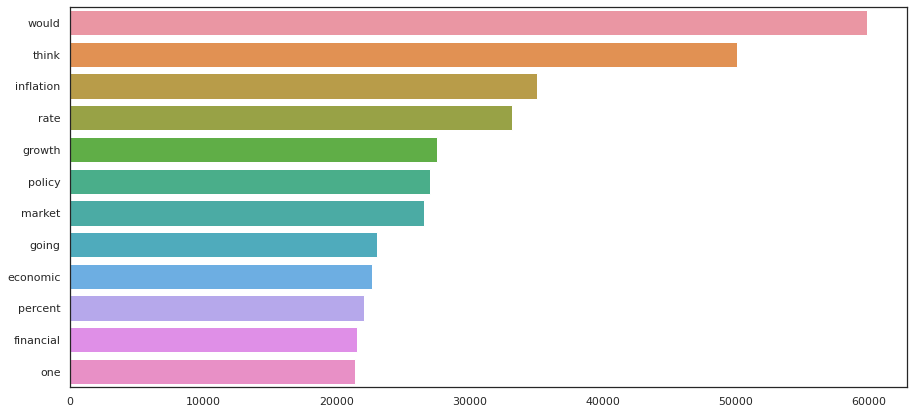

In [33]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

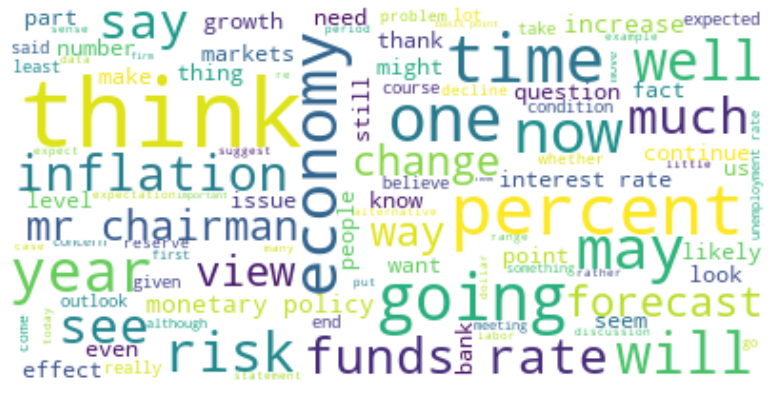

In [34]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


In [35]:
# Load sentiment data
sentiment_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/LoughranMcDonald_SentimentWordLists_2018.csv')
print(sentiment_df.shape)
sentiment_df

(4140, 2)


,sentiment,word
0,Negative,ABANDON
1,Negative,ABANDONED
2,Negative,ABANDONING
3,Negative,ABANDONMENT
4,Negative,ABANDONMENTS
...,...,...
4135,Constraining,STRICTER
4136,Constraining,STRICTEST
4137,Constraining,STRICTLY
4138,Constraining,UNAVAILABILITY


In [36]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,184
Litigious,904
Negative,2355
Positive,354
StrongModal,19
Uncertainty,297
WeakModal,27


In [37]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [38]:
# Consider Negation
negate = ["cannot", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [39]:
# Analyze tone for original text dataframe
print(text_df.shape)
tone_keyword_lm = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm(text_df['text'], total=text_df.shape[0])]
tone_keyword_lm_df = pd.DataFrame(tone_keyword_lm, columns=columns)
text_df = pd.concat([text_df, tone_keyword_lm_df.reindex(text_df.index)], axis=1)
text_df


(7908, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0.000000,99,1,1,[enhance],[misunderstanding]
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,0.000000,40,0,0,[],[]
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,0.000000,37,0,0,[],[]
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",0.000000,57,0,0,[],[]
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",0.000000,51,0,0,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7903,testimony,2020-05-19,Coronavirus and CARES Act,Jerome Powell,1802,<NA>,None,2020-06-10,0,0.00,I would like to begin by acknowledging the tra...,-0.665927,1802,33,45,"[tremendous, greatly, able, gains, great, trem...","[tragic, loss, hardship, crisis, closed, curta..."
7904,testimony,2020-06-16,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1433,<NA>,None,2020-07-29,0,0.00,Our country continues to face a difficult and ...,-0.907188,1433,30,43,"[tremendous, positive, able, greater, progress...","[difficult, challenging, hardship, crisis, une..."
7905,testimony,2020-06-30,Coronavirus and CARES Act,Jerome Powell,2759,<NA>,None,2020-07-29,0,0.00,We meet as the pandemic continues to cause tre...,-0.108735,2759,46,49,"[tremendous, tremendous, greater, rebounded, p...","[hardship, crisis, decline, losses, decline, s..."
7906,testimony,2020-09-22,"Coronavirus Aid, Relief, and Economic Security...",Jerome Powell,2400,<NA>,None,2020-11-05,0,NaN,"Chairwoman Waters, Ranking Member McHenry, and...",-0.041667,2400,25,26,"[opportunity, strong, improvement, rebounded, ...","[hardship, fallout, damage, depressed, shut, d..."


In [40]:
# Analyze tone for training dataframe
tone_lmdict_list = []
for doc_type in doc_types:
    tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x)[0] for x in tqdm(train_df[doc_type], 
                                                                                      total=train_df.shape[0], 
                                                                                      desc=doc_type)]
    tone_lmdict_list.append(tone_lmdict)
    
train_df['tone'] = np.mean(tone_lmdict_list, axis=0)
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,meeting_script,speech,testimony,text,tone
date,,,,,,,,,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,,,,,0.000000
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,,,VOLCKER.while but it may be that itsurprised ...,,,VOLCKER.while but it may be that itsurprised ...,-0.245722
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723,,,,VOLCKER.Let me just make a couple of comments...,,,VOLCKER.Let me just make a couple of comments...,-0.217865
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723,,,,VOLCKER.the agenda] a bit today since the sho...,,,VOLCKER.the agenda] a bit today since the sho...,-0.159293
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,,,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279,The fundamentals of the U.S. economy remain s...,,Earlier today the Federal Open Market Committ...,,,,The fundamentals of the U.S. economy remain s...,0.396825
2020-03-19,0,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426,The coronavirus outbreak has harmed communiti...,Developments in Financial Markets and Open Ma...,"Good evening, everyone. Today the Federal Res...",,,,The coronavirus outbreak has harmed communiti...,-0.352567
2020-03-23,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426,,,,,,,,0.000000


In [41]:
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,meeting_script,speech,testimony,text,tone
date,,,,,,,,,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,,,,,0.000000
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,,,VOLCKER.while but it may be that itsurprised ...,,,VOLCKER.while but it may be that itsurprised ...,-0.245722
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723,,,,VOLCKER.Let me just make a couple of comments...,,,VOLCKER.Let me just make a couple of comments...,-0.217865
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723,,,,VOLCKER.the agenda] a bit today since the sho...,,,VOLCKER.the agenda] a bit today since the sho...,-0.159293
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,,,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279,The fundamentals of the U.S. economy remain s...,,Earlier today the Federal Open Market Committ...,,,,The fundamentals of the U.S. economy remain s...,0.396825
2020-03-19,0,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426,The coronavirus outbreak has harmed communiti...,Developments in Financial Markets and Open Ma...,"Good evening, everyone. Today the Federal Res...",,,,The coronavirus outbreak has harmed communiti...,-0.352567
2020-03-23,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426,,,,,,,,0.000000


In [43]:
# Show corelations to next_decision TODO
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
#corr_columns = ['target', 'tone', 'prev_decision']
#sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax1, vmin=0, vmax=1)
#ax1.set_title("Correlation of train_df")
#corr_columns = ['next_decision', 'tone_score', 'decision']
#sns.heatmap(text_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax2, vmin=0, vmax=1)
#ax2.set_title("Correlation of text_df")
#plt.show()

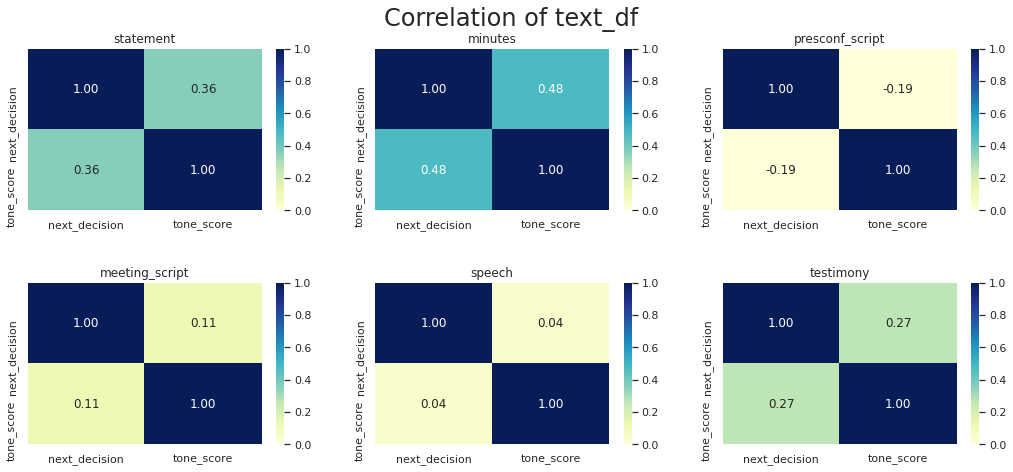

In [44]:
# Per document type
corr_columns = ['next_decision', 'tone_score', 'type']
doc_types = ['statement', 'minutes', 'presconf_script', 'meeting_script', 'speech', 'testimony']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
df = text_df[corr_columns]
for i, doc_type in enumerate(doc_types):
    sns.heatmap(df.loc[df['type'] == doc_type].drop(columns=['type']).astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(doc_type)

fig.suptitle('Correlation of text_df', fontsize=24)
fig.tight_layout(pad=3.0)
plt.show()

In [45]:
def lemmatize_word(word):
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='text'):
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it loser case
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        # Lemmatize words 
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized


In [46]:
tokenized_org = tokenize_df(text_df)
print('len(tokenized_org): ', len(tokenized_org))
print(tokenized_org[0])


len(tokenized_org):  7908
['chairman', 'alan', 'greenspan', 'announce', 'today', 'federal', 'open', 'market', 'committee', 'decide', 'increase', 'slightly', 'degree', 'pressure', 'reserve', 'position', 'the', 'action', 'expect', 'associate', 'small', 'increase', 'money', 'market', 'interest', 'rate', 'the', 'decision', 'take', 'move', 'toward', 'le', 'accommodative', 'stance', 'monetary', 'policy', 'order', 'sustain', 'enhance', 'economic', 'expansion', 'chairman', 'greenspan', 'decide', 'announce', 'action', 'immediately', 'avoid', 'misunderstand', 'committee', 'purpose', 'give', 'fact', 'first', 'firm', 'reserve', 'market', 'condition', 'committee', 'since', 'early']


In [47]:
# Concat the list to create docs
lemma_docs_org = [" ".join(words) for words in tokenized_org]
print('len(lemma_docs_org): ', len(lemma_docs_org))
print(lemma_docs_org[0])

len(lemma_docs_org):  7908
chairman alan greenspan announce today federal open market committee decide increase slightly degree pressure reserve position the action expect associate small increase money market interest rate the decision take move toward le accommodative stance monetary policy order sustain enhance economic expansion chairman greenspan decide announce action immediately avoid misunderstand committee purpose give fact first firm reserve market condition committee since early


In [48]:
# Create a list of all the words in the dataframe
all_words_org = [word for text in tokenized_org for word in text]
print('len(all_words_org): ', len(all_words_org))
print(all_words_org[0])

# Counter object of all the words
counts_org = Counter(all_words_org)
print('len(counts_org): ', len(counts_org))

# Create a Bag of Word, sorted by the count of words
bow_org = sorted(counts_org, key=counts_org.get, reverse=True)
print('bow_org[:20]', bow_org[:20])

# Indexing vocabrary, starting from 1.
vocab_org = {word: ii for ii, word in enumerate(counts_org, 1)}
id2vocab_org = {v: k for k, v in vocab_org.items()}

print("vocab_org['chairman']: ", vocab_org['chairman'])
print("vocab_org['market']: ", vocab_org['market'])

len(all_words_org):  6570266
chairman
len(counts_org):  194766
bow_org[:20] ['i', 'rate', 'would', 'think', 'market', 'inflation', 'the', 'policy', 'go', 'price', 'year', 'growth', 'percent', 'say', 'increase', 'economy', 'time', 'one', 'point', 'see']
vocab_org['chairman']:  1
vocab_org['market']:  8


In [49]:
# Create token id list
token_ids_org = [[vocab_org[word] for word in text_words] for text_words in tokenized_org]
print(len(token_ids_org))

7908


In [50]:
# Add to the dataframe
text_df['tokenized'] = tokenized_org
text_df['token_ids'] = token_ids_org

In [53]:
tokenized = tokenize_df(train_df)
print('len(tokenized): ', len(tokenized))
print(tokenized[0])

# Concat the list to create docs
lemma_docs = [" ".join(words) for words in tokenized]
print('len(lemma_docs): ', len(lemma_docs))
print(lemma_docs[0])

# Create a list of all the words in the dataframe
all_words = [word for text in tokenized for word in text]
print('len(all_words): ', len(all_words))
print(all_words[0])

# Counter object of all the words
counts = Counter(all_words)
print('len(counts): ', len(counts))

# Create a Bag of Word, sorted by the count of words
bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

# Indexing vocabrary, starting from 1.
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

# Create token id list
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]
print(len(token_ids))

# Add to the dataframe
train_df['tokenized'] = tokenized
train_df['token_ids'] = token_ids
train_df['tokenized_text'] = train_df['tokenized'].apply(lambda x: " ".join(x))


len(tokenized):  398
[]
len(lemma_docs):  398

len(all_words):  6508077
may
len(counts):  194294
bow[:20] ['i', 'rate', 'would', 'think', 'market', 'inflation', 'the', 'policy', 'go', 'price', 'year', 'growth', 'percent', 'say', 'increase', 'economy', 'time', 'one', 'point', 'see']
398


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


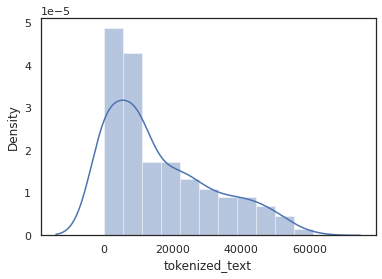

In [54]:
sns.distplot(train_df['tokenized_text'].apply(lambda x: len(x.split())))

In [55]:
len(token_ids[0])

0

## Lemmatize sentiment

In [56]:
# pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [57]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,145
Litigious,750
Negative,2355
Positive,354
StrongModal,15
Uncertainty,257


## Tfidf 

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    vectorizer = TfidfVectorizer(analyzer='word', vocabulary=sentiment_words)
    tfidf = vectorizer.fit_transform(docs)
    features = vectorizer.get_feature_names()
    
    return tfidf.toarray()

### Text dataframe

In [59]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf_org = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf_org['Negative']))
print(len(sentiment_tfidf_org['Negative'][0]))

7908
2355


In [60]:
text_df.shape

(7908, 19)

In [61]:
for sentiment in lemma_sentiments:
    text_df['tfidf_' + sentiment] = list(sentiment_tfidf_org[sentiment])
    
text_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words,tokenized,token_ids,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0.000000,99,1,1,[enhance],[misunderstanding],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,0.000000,40,0,0,[],[],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,0.000000,37,0,0,[],[],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 15, 11, 12, 13, 14, 15, 16,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",0.000000,57,0,0,[],[],"[in, take, discount, action, board, approve, r...","[51, 26, 52, 18, 53, 54, 55, 56, 53, 57, 58, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",0.000000,51,0,0,[],[],"[in, take, discount, rate, action, board, appr...","[51, 26, 52, 24, 18, 53, 54, 55, 56, 53, 57, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7903,testimony,2020-05-19,Coronavirus and CARES Act,Jerome Powell,1802,<NA>,None,2020-06-10,0,0.00,I would like to begin by acknowledging the tra...,-0.665927,1802,33,45,"[tremendous, greatly, able, gains, great, trem...","[tragic, loss, hardship, crisis, closed, curta...","[i, would, like, begin, acknowledge, tragic, l...","[1513, 138, 1220, 526, 1957, 537, 713, 1308, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.18814288193265657, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.7181093534580485, 0.0, ..."
7904,testimony,2020-06-16,Semiannual Monetary Policy Rep

### Train dataframe

In [62]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf['Negative']))
print(len(sentiment_tfidf['Negative'][0]))

for sentiment in lemma_sentiments:
    train_df['tfidf_' + sentiment] = list(sentiment_tfidf[sentiment])
    
train_df

398
2355


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,meeting_script,speech,testimony,text,tone,tokenized,token_ids,tokenized_text,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,,,,,0.000000,[],[],,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,,,VOLCKER.while but it may be that itsurprised ...,,,VOLCKER.while but it may be that itsurprised ...,-0.245722,"[may, itsurprised, werewe, thatin, think, leve...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 11, 12, 13,...",may itsurprised werewe thatin think level long...,"[0.026567092987580566, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.04731782110398969, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.11569578425810761, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.25235607509521585, 0.4216869820597739, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.05695561546696836, 0.10..."
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723,,,,VOLCKER.Let me just make a couple of comments...,,,VOLCKER.Let me just make a couple of comments...,-0.217865,"[make, couple, think, question, mechanism, cre...","[351, 758, 5, 11, 2727, 2728, 2729, 63, 2280, ...",make couple think question mechanism creep isa...,"[0.03354928439626667, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.17270518295102177, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.058618697897538825, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.39560328262486677, 0.07932636657789696, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723,,,,VOLCKER.the agenda] a bit today since the sho...,,,VOLCKER.the agenda] a bit today since the sho...,-0.159293,"[agenda, bite, today, since, short, run, blend...","[3437, 467, 927, 338, 278, 273, 4371, 272, 437...",agenda bite today since short run blend long r...,"[0.023758687869510478, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0942685728091519, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0180386493983937, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.49326338986727, 0.37090938892534997, 0.0889...","[0.0, 0.0, 0.0, 0.0, 0.11589901385884228, 0.10..."
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,,,0.000000,[],[],,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279,The fundamentals of the U.S. economy remain s...,,Earlier today the Federal Open Market Committ...,,,,The fundamentals of the U.S. economy remain s...,0.396825,"[the, fundamental, economy, remain, strong, ho...","[15, 2062, 720, 760, 919, 12, 194151, 5936, 14...",the fundamental economy remain strong however ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 

Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    #print(tfidf_matrix)
    return [cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0][0].tolist() for u, v in zip(tfidf_matrix, tfidf_matrix[1:])]

In [64]:
cosine_similarities = {
    sentiment_name: get_cosine_similarity(sentiment_values) 
    for sentiment_name, sentiment_values in sentiment_tfidf.items()}

print(len(cosine_similarities['Negative']))

397


In [65]:
for sentiment in lemma_sentiments:
    # Add 0 to the first element as there is no comparison available to a previous value
    cosine_similarities[sentiment].insert(0, 0)
    train_df['cos_sim_' + sentiment] = cosine_similarities[sentiment]
    
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,meeting_script,speech,testimony,text,tone,tokenized,token_ids,tokenized_text,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining,cos_sim_Negative,cos_sim_Positive,cos_sim_Uncertainty,cos_sim_Litigious,cos_sim_StrongModal,cos_sim_Constraining
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,,,,,0.000000,[],[],,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,,,VOLCKER.while but it may be that itsurprised ...,,,VOLCKER.while but it may be that itsurprised ...,-0.245722,"[may, itsurprised, werewe, thatin, think, leve...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 11, 12, 13,...",may itsurprised werewe thatin think level long...,"[0.026567092987580566, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.04731782110398969, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.11569578425810761, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.25235607509521585, 0.4216869820597739, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.05695561546696836, 0.10...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723,,,,VOLCKER.Let me just make a couple of comments...,,,VOLCKER.Let me just make a couple of comments...,-0.217865,"[make, couple, think, question, mechanism, cre...","[351, 758, 5, 11, 2727, 2728, 2729, 63, 2280, ...",make couple think question mechanism creep isa...,"[0.03354928439626667, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.17270518295102177, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.058618697897538825, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.39560328262486677, 0.07932636657789696, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.731049,0.735255,0.962253,0.700455,0.695310,0.743343
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723,,,,VOLCKER.the agenda] a bit today since the sho...,,,VOLCKER.the agenda] a bit today since the sho...,-0.159293,"[agenda, bite, today, since, short, run, blend...","[3437, 467, 927, 338, 278, 273, 4371, 272, 437...",agenda bite today since short run blend long r...,"[0.023758687869510478, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0942685728091519, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0180386493983937, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.49326338986727, 0.37090938892534997, 0.0889...","[0.0, 0.0, 0.0, 0.0, 0.11589901385884228, 0.10...",0.735695,0.694744,0.955093,0.698824,0.906911,0.871150
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,,,0.000000,[],[],,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279,The fundamentals of the U.S. economy remain s...,,Earlier today the Federal Open Market Committ...,,,,The fundamentals of the U.S. economy remain s...,0.396825,"[the, fundam

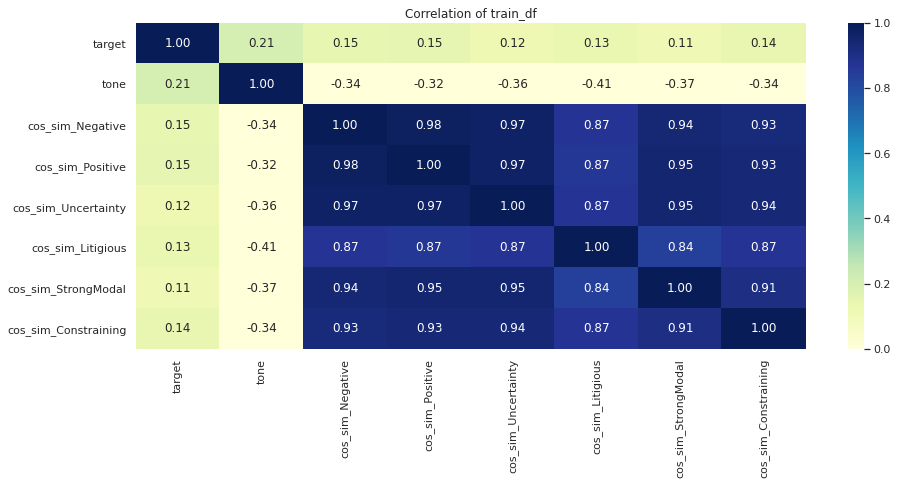

In [66]:
# Show corelations to target
fig, ax = plt.subplots(figsize=(15,6))
corr_columns = ['target', 'tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax, vmin=0, vmax=1)
ax.set_title("Correlation of train_df")
plt.show()

### Convert target class for classification

In [67]:
def convert_class(x):
    if x == 1:
        return 2
    elif x == 0:
        return 1
    elif x == -1:
        return 0

In [68]:
train_df['target'] = train_df['target'].map(convert_class)

In [69]:
train_df['prev_decision'] = train_df['prev_decision'].map(convert_class)

## Modeling and Training

In [71]:
# Use GPU
#if IN_COLAB:
#  torch.cuda.get_device_name(0)

In [72]:
# Use Stratified KFold Cross Validation
# Training data is not so many, keep n_split <= 5
kfold = StratifiedKFold(n_splits=3)
kfold

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [73]:
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [74]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


## A. Cosin Similarity
### Train and Test Data

In [75]:
train_df.columns

Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'statement',
       'minutes', 'presconf_script', 'meeting_script', 'speech', 'testimony',
       'text', 'tone', 'tokenized', 'token_ids', 'tokenized_text',
       'tfidf_Negative', 'tfidf_Positive', 'tfidf_Uncertainty',
       'tfidf_Litigious', 'tfidf_StrongModal', 'tfidf_Constraining',
       'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty',
       'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining'],
      dtype='object')

In [76]:
# X and Y data used
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 
                                     'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

### Train

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed:    2.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.6s finished
[2021-01-24 20:14:08,935][INFO] ## Training - acc: 0.99056604, f1: 0.98753492
[2021-01-24 20:14:08,937][INFO] ## Test - acc: 0.61250000, f1: 0.46979718


Best Score:  0.5695549345249169
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 27}


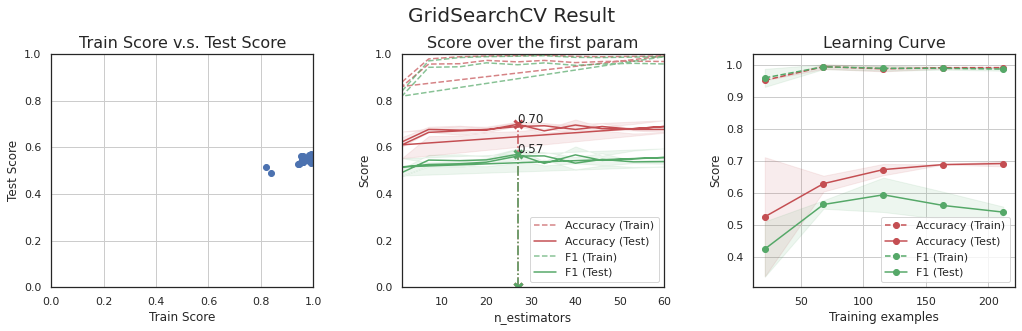

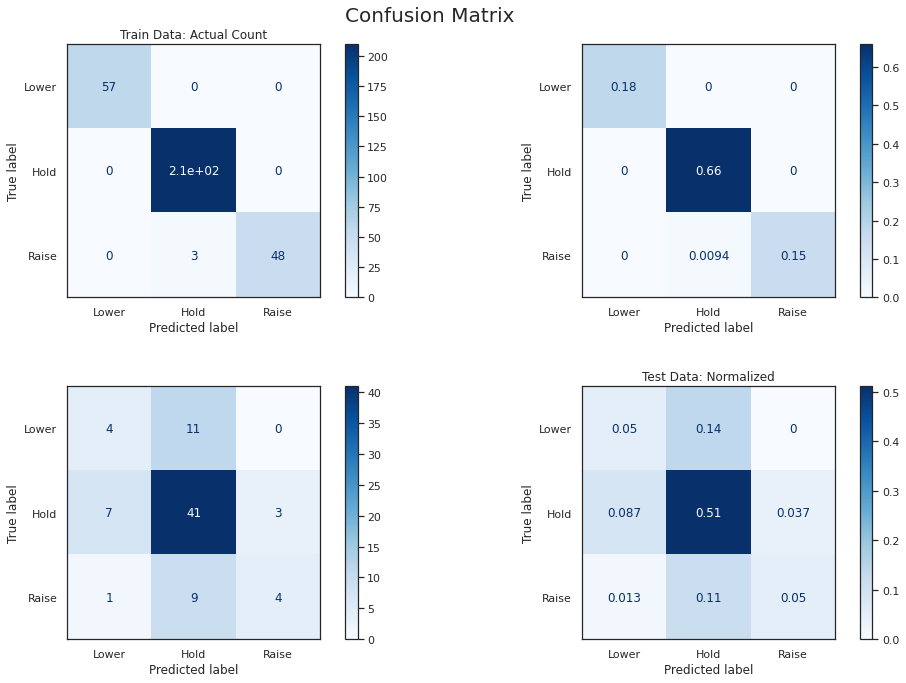

In [77]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [3, 10],
              'min_samples_leaf': [3],
              'max_features': [7],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

Text(0.5, 1.0, 'Feature importance')

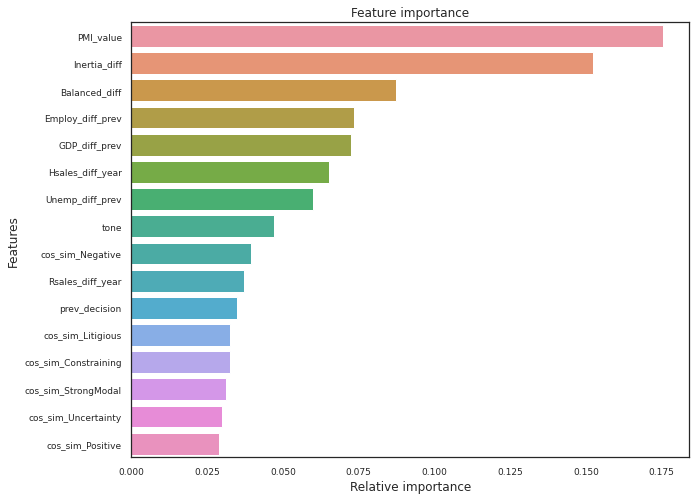

In [78]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")


## B. Tfidf
Use Tfidf instead of cosin similarity
### Train and Test Data

In [79]:
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,meeting_script,speech,testimony,text,tone,tokenized,token_ids,tokenized_text,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining,cos_sim_Negative,cos_sim_Positive,cos_sim_Uncertainty,cos_sim_Litigious,cos_sim_StrongModal,cos_sim_Constraining
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982-10-05,0,1,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,,,,,0.000000,[],[],,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1982-11-16,0,0,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,,,VOLCKER.while but it may be that itsurprised ...,,,VOLCKER.while but it may be that itsurprised ...,-0.245722,"[may, itsurprised, werewe, thatin, think, leve...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 11, 12, 13,...",may itsurprised werewe thatin think level long...,"[0.026567092987580566, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.04731782110398969, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.11569578425810761, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.25235607509521585, 0.4216869820597739, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.05695561546696836, 0.10...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1982-12-21,1,0,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723,,,,VOLCKER.Let me just make a couple of comments...,,,VOLCKER.Let me just make a couple of comments...,-0.217865,"[make, couple, think, question, mechanism, cre...","[351, 758, 5, 11, 2727, 2728, 2729, 63, 2280, ...",make couple think question mechanism creep isa...,"[0.03354928439626667, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.17270518295102177, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.058618697897538825, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.39560328262486677, 0.07932636657789696, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.731049,0.735255,0.962253,0.700455,0.695310,0.743343
1983-01-14,1,1,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723,,,,VOLCKER.the agenda] a bit today since the sho...,,,VOLCKER.the agenda] a bit today since the sho...,-0.159293,"[agenda, bite, today, since, short, run, blend...","[3437, 467, 927, 338, 278, 273, 4371, 272, 437...",agenda bite today since short run blend long r...,"[0.023758687869510478, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0942685728091519, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0180386493983937, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.49326338986727, 0.37090938892534997, 0.0889...","[0.0, 0.0, 0.0, 0.0, 0.11589901385884228, 0.10...",0.735695,0.694744,0.955093,0.698824,0.906911,0.871150
1983-01-21,1,1,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,,,0.000000,[],[],,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279,The fundamentals of the U.S. economy remain s...,,Earlier today the Federal Open Market Committ...,,,,The fundamentals of the U.S. economy remain s...,0.396825,"[the, fundamental,

In [80]:
vocabulary=sentiment_dict['Negative']+sentiment_dict['Positive']

In [81]:
# X and Y data used
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'tokenized_text']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

In [82]:
import scipy
def get_numeric_data(x):
    return [record[:-2].astype(float) for record in x]

def get_text_data(x):
    return [record[-1] for record in x]

from sklearn.preprocessing import FunctionTransformer
transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

clf = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word', vocabulary=vocabulary))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed:   19.8s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   23.7s finished


Best Score:  0.2819273459665137
Best Param:  {'clf__bootstrap': False, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 7, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 3, 'clf__n_estimators': 1}


[2021-01-24 20:14:43,036][INFO] ## Training - acc: 0.66352201, f1: 0.35070894
[2021-01-24 20:14:43,039][INFO] ## Test - acc: 0.67500000, f1: 0.26865672


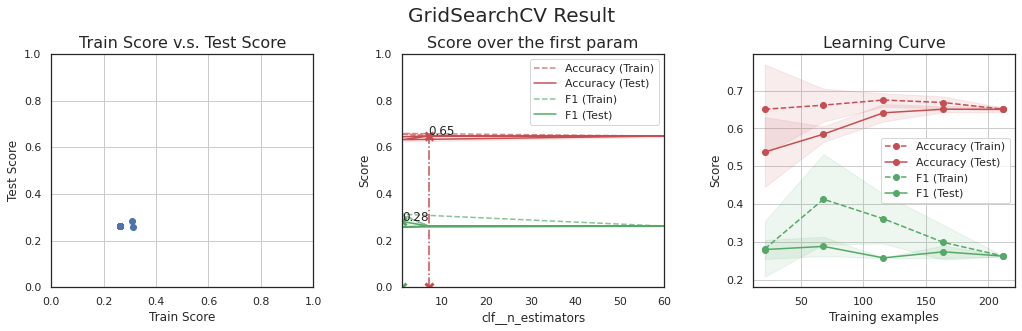

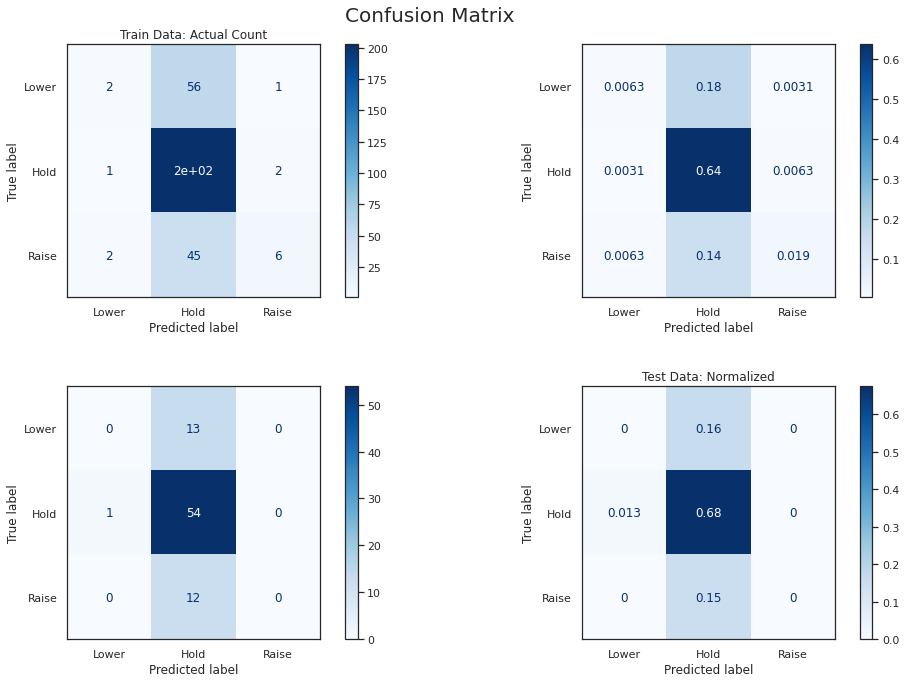

In [83]:
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word'))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

# Perform Grid Search
param_grid = {'clf__n_estimators': np.linspace(1, 60, 10, dtype=int),
              'clf__min_samples_split': [3, 10],
              'clf__min_samples_leaf': [3],
              'clf__max_features': [7],
              'clf__max_depth': [None],
              'clf__criterion': ['gini'],
              'clf__bootstrap': [False]}

rf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_


## C. LSTM (RNN)
Instead of Tfidf, use LSTM. Concatinate the lstm output and the meta data at the end and dense layer to fully connect them.

### Input Data

In [84]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'token_ids']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

X_train_meta = get_numeric_data(X_train)
X_train_text = get_text_data(X_train)
X_valid_meta = get_numeric_data(X_valid)
X_valid_text = get_text_data(X_valid)

print('Shape of train meta', len(X_train_meta))
print('Shape of train text', len(X_train_text))
print("Shape of valid meta ", len(X_valid_meta))
print("Shape of valid text ", len(X_valid_text))

meta_size = len(X_train_meta[0])
print("Meta data size: ", meta_size)

Shape of train meta 318
Shape of train text 318
Shape of valid meta  80
Shape of valid text  80
Meta data size:  9


### Model
#### Embed -> RNN -> Dense -> Softmax

In [85]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, meta_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, nn_input_meta, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(concat_layer)
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

can use keras functions but let's do it from scratch

In [86]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 100
# tokenizer_obj = Tokenizer()
# tokenizer_obj.fit_on_texts(balanced['texts'])
# sequences = tokenizer_obj.texts_to_sequences(balanced['texts'])

# text_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
# text_pad

In [87]:
def dataloader(messages, meta, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        meta = [meta[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # print(len(tokens))
            # print(len(tokens[0]))
            # print(token_tensor.shape)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            # print(token_tensor[:sequence_length].shape)
            # print(start_idx, batch_num)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        meta_tensor = torch.tensor(meta[ii: ii+len(batch_messages)])
        
        yield batch, meta_tensor, label_tensor

In [88]:
# Test
text_batch, meta_batch, labels = next(iter(dataloader(X_train_text, X_train_meta, y_train)))
model = TextClassifier(len(vocab), 512, 128, 8, meta_size, 3)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, meta_batch, hidden)
print(logps)

tensor([[-7.7699e+01, -8.2748e+01,  0.0000e+00],
        [-6.9520e+01, -8.0019e+01,  0.0000e+00],
        [-6.9277e+01, -8.0216e+01,  0.0000e+00],
        [-8.3043e+01, -8.5563e+01,  0.0000e+00],
        [-1.1487e+02, -1.1349e+02,  0.0000e+00],
        [-8.7381e+01, -9.3830e+01,  0.0000e+00],
        [-6.3291e+01, -6.8027e+01,  0.0000e+00],
        [ 0.0000e+00, -2.3548e+01, -4.1091e+01],
        [-5.7899e+01, -6.7956e+01,  0.0000e+00],
        [ 0.0000e+00, -3.5360e+01, -6.8532e+01],
        [-6.6127e+00, -2.3549e+01, -1.3441e-03],
        [-8.2564e+01, -8.6956e+01,  0.0000e+00],
        [-8.4720e+01, -8.5830e+01,  0.0000e+00],
        [-6.9143e+01, -7.5792e+01,  0.0000e+00],
        [-8.3053e+01, -8.5355e+01,  0.0000e+00],
        [-9.7167e-03, -1.9053e+01, -4.6388e+00]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Configure the model and train!

In [89]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(len(vocab)+1, 512, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(194295, 512)
  (lstm): LSTM(512, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [90]:
def train_model(model, epochs=3, batch_size=8, learning_rate=1e-4, sequence_length=200, clip=5, print_every=950):
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  model.train()

  for epoch in range(epochs):
    print('Starting epoch {}'.format(epoch + 1))
    hidden = model.init_hidden(batch_size)
    steps = 0
    y_valid_epoch = []
    predicted_valid_epoch = []
    
    for text_batch, meta_batch, labels in dataloader(X_train_text, X_train_meta, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
      steps += 1
      # Skip the last batch of which size is not equal to batch_size
      if text_batch.size(1) != batch_size:
        break

      # Creating new variables for the hidden state to avoid backprop entire training history
      hidden = tuple([each.data for each in hidden])
  
      # Set Device
      text_batch, meta_batch, labels = text_batch.to(device), meta_batch.to(device), labels.to(device)
      for each in hidden:
          each.to(device)
  
      # optimizer.zero_grad()
      model.zero_grad()
  
      # Get output and hidden state from the model
      output, hidden = model(text_batch, meta_batch, hidden)

      # Calculate the loss and perform backprop
      loss = criterion(output, labels)
      loss.backward()

      # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
      nn.utils.clip_grad_norm_(model.parameters(), clip)

      # Optimize
      optimizer.step()

      if steps % print_every == 0:
        model.eval()
        valid_losses = []
        accuracy = []
        predicted_valid = []
        y_valid_batch = []
        valid_hidden = model.init_hidden(batch_size)
        
        for text_batch, meta_batch, labels in dataloader(X_valid_text, X_valid_meta, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
          # Skip the last batch of which size is not equal to batch_size
          if text_batch.size(1) != batch_size:
            break

          # Initialize within the loop to use label shape because batch_size did not work
          # valid_hidden = model.init_hidden(labels.shape[0])

          # Creating new variables for the hidden state
          valid_hidden = tuple([each.data for each in valid_hidden])

          # Set Device
          text_batch, meta_batch, labels = text_batch.to(device), meta_batch.to(device), labels.to(device)
          for each in valid_hidden:
              each.to(device)

          # Get output and hidden state from the model
          valid_output, valid_hidden = model(text_batch, meta_batch, valid_hidden)

          # Calculate the loss     
          valid_loss = criterion(valid_output.squeeze(), labels)
          valid_losses.append(valid_loss.item())

          # Accuracy
          ps = torch.exp(valid_output)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

          predicted_valid.extend(top_class.squeeze().cpu().numpy())
          y_valid_batch.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

          model.train()
          acc, f1 = metric(y_valid_batch, predicted_valid)
          predicted_valid_epoch.extend(predicted_valid)
          y_valid_epoch.extend(y_valid_batch)

          print("Epoch: {}/{}...".format(epoch+1, epochs), "Step: {}...".format(steps), "Loss: {:.6f}...".format(loss.item()), "Val Loss: {:.6f}".format(np.mean(valid_losses)), "Accuracy: {:.6f}".format(acc), "F1 Score: {:.6f}".format(f1))
        print("{} steps in epoch {}".format(steps, epoch+1))
        class_names = ['Lower', 'Hold', 'Raise']
        y_valid_class = [class_names[int(idx)] for idx in y_valid_batch]
        predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
        titles_options = [("Confusion matrix, without normalization", None), ("Confusion matrix, with normalization", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
        acc, f1 = metric(y_valid_class, predicted_valid_class)
        print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
        plt.show()

In [91]:
#train_model(model)

## D. Glove Word Embedding + LSTM
Use GloVe word embedding instead of Tfidf

In [93]:
glove_file = 'glove.6B.300d.pickle'
glove_path = glove_dir + glove_file
embedding_dict = {}
with open("/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/glove.6B.300d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:], 'float32')
    embedding_dict[word] = vectors
f.close()
pickle.dump(embedding_dict, open(glove_path, 'wb'))


In [94]:
glove_dict = pickle.load(open(glove_path, 'rb'))
print(len(glove_dict))
glove_dict['the']


400000


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [95]:
weight_matrix = np.zeros((len(vocab), 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)


20519 words found out of 194294 words in vocab.
(194294, 300)


In [96]:
type(weight_matrix)


numpy.ndarray

In [97]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, dense_size, meta_size, output_size, lstm_layers=1, dropout=0.1):
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, nn_input_meta, hidden_state):
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(concat_layer)
        logps = self.softmax(out)

        return logps, hidden_state


### Configure the model and train!

In [98]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.to(device)


GloveTextClassifier(
  (embedding): Embedding(194294, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [99]:
train_model(model)


Starting epoch 1
Starting epoch 2
Starting epoch 3


The result does not look good. In fact, only the first hunderds of text can be used. Now, consider to split the text to the length of 200 with overlapping 50 words again.

In [100]:
train_df.columns


Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'statement',
       'minutes', 'presconf_script', 'meeting_script', 'speech', 'testimony',
       'text', 'tone', 'tokenized', 'token_ids', 'tokenized_text',
       'tfidf_Negative', 'tfidf_Positive', 'tfidf_Uncertainty',
       'tfidf_Litigious', 'tfidf_StrongModal', 'tfidf_Constraining',
       'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty',
       'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining'],
      dtype='object')

In [101]:
split_train_df = train_df.drop(columns=['statement',
       'minutes', 'speech', 'testimony',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_StrongModal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_StrongModal', 'cos_sim_Constraining'])


In [102]:
split_train_df.shape


(398, 14)

In [103]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total
def get_split_df(df, split_len=200, overlap=50):
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            #row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    return split_df


In [104]:
split_train_df = get_split_df(split_train_df)
split_train_df.shape


(81124, 14)

In [105]:
tokenized = tokenize_df(split_train_df)
lemma_docs = [" ".join(words) for words in tokenized]
all_words = [word for text in tokenized for word in text]
counts = Counter(all_words)
bow = sorted(counts, key=counts.get, reverse=True)
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

# Add to the dataframe
split_train_df['token_ids'] = token_ids


In [106]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))


In [107]:
split_train_df.head()


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,presconf_script,meeting_script,text,tone,token_ids
0,0,1,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,0.000000,[]
1,0,0,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,VOLCKER.while but it may be that itsurprised ...,VOLCKER while but it may be that itsurprised m...,-0.245722,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,0,0,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,VOLCKER.while but it may be that itsurprised ...,the guy payingthe highest rate And that will t...,-0.245722,"[63, 64, 65, 35, 66, 67, 68, 35, 69, 70, 8, 71..."
3,0,0,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,VOLCKER.while but it may be that itsurprised ...,going on particularly with respect to Argentin...,-0.245722,"[22, 120, 121, 122, 123, 124, 88, 125, 126, 12..."
4,0,0,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,VOLCKER.while but it may be that itsurprised ...,case of Mexico I don't know if it's goingto co...,-0.245722,"[132, 175, 7, 176, 177, 25, 7, 178, 76, 179, 1..."


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


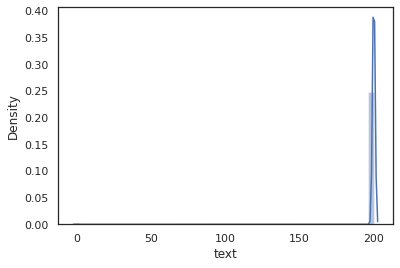

In [108]:
sns.distplot(split_train_df['text'].apply(lambda x: len(x.split())))


In [109]:
# X and Y data used
y_data = split_train_df['target']
X_data = split_train_df[nontext_columns + ['tone', 'token_ids']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

X_train_meta = get_numeric_data(X_train)
X_train_text = get_text_data(X_train)
X_valid_meta = get_numeric_data(X_valid)
X_valid_text = get_text_data(X_valid)

print('Shape of train meta', len(X_train_meta))
print('Shape of train text', len(X_train_text))
print("Shape of valid meta ", len(X_valid_meta))
print("Shape of valid text ", len(X_valid_text))

meta_size = len(X_train_meta[0])
print("Meta data size: ", meta_size)


Shape of train meta 64899
Shape of train text 64899
Shape of valid meta  16225
Shape of valid text  16225
Meta data size:  9


In [110]:
len(weight_matrix)


202687

In [111]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.to(device)


GloveTextClassifier(
  (embedding): Embedding(202687, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Starting epoch 1
Epoch: 1/3... Step: 950... Loss: 5.273826... Val Loss: 8.890366 Accuracy: 0.687500 F1 Score: 0.271605
Epoch: 1/3... Step: 950... Loss: 5.273826... Val Loss: 4.749669 Accuracy: 0.718750 F1 Score: 0.289308
Epoch: 1/3... Step: 950... Loss: 5.273826... Val Loss: 4.851613 Accuracy: 0.687500 F1 Score: 0.378120
Epoch: 1/3... Step: 950... Loss: 5.273826... Val Loss: 5.302169 Accuracy: 0.640625 F1 Score: 0.369152
Epoch: 1/3... Step: 950... Loss: 5.273826... Val Loss: 5.252441 Accuracy: 0.637500 F1 Score: 0.395442
Epoch: 1/3... Step: 950... Loss: 5.273826... Val Loss: 4.784701 Accuracy: 0.614583 F1 Score: 0.379120
Epoch: 1/3... Step: 950... Loss: 5.273826... Val Loss: 4.624412 Accuracy: 0.625000 F1 Score: 0.406781
Epoch: 1/3... Step: 950... Loss: 5.273826... Val Loss: 4.769303 Accuracy: 0.609375 F1 Score: 0.413444
Epoch: 1/3... Step: 950... Loss: 5.273826... Val Loss: 4.770870 Accuracy: 0.618056 F1 Score: 0.417194
Epoch: 1/3... Step: 950... Loss: 5.273826... Val Loss: 4.719895 A

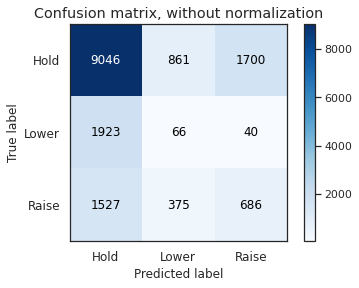

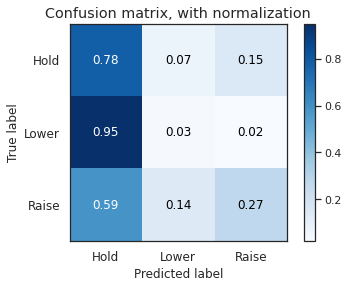

Epoch: 1/3... Step: 1900... Loss: 0.720484... Val Loss: 0.568588 Accuracy: 0.750000 F1 Score: 0.285714
Epoch: 1/3... Step: 1900... Loss: 0.720484... Val Loss: 0.525477 Accuracy: 0.781250 F1 Score: 0.424242
Epoch: 1/3... Step: 1900... Loss: 0.720484... Val Loss: 0.669165 Accuracy: 0.729167 F1 Score: 0.426629
Epoch: 1/3... Step: 1900... Loss: 0.720484... Val Loss: 0.802069 Accuracy: 0.656250 F1 Score: 0.372549
Epoch: 1/3... Step: 1900... Loss: 0.720484... Val Loss: 0.802368 Accuracy: 0.637500 F1 Score: 0.367111
Epoch: 1/3... Step: 1900... Loss: 0.720484... Val Loss: 0.785097 Accuracy: 0.645833 F1 Score: 0.395646
Epoch: 1/3... Step: 1900... Loss: 0.720484... Val Loss: 0.790504 Accuracy: 0.651786 F1 Score: 0.401046
Epoch: 1/3... Step: 1900... Loss: 0.720484... Val Loss: 0.840521 Accuracy: 0.625000 F1 Score: 0.376701
Epoch: 1/3... Step: 1900... Loss: 0.720484... Val Loss: 0.865555 Accuracy: 0.631944 F1 Score: 0.368396
Epoch: 1/3... Step: 1900... Loss: 0.720484... Val Loss: 0.870913 Accuracy

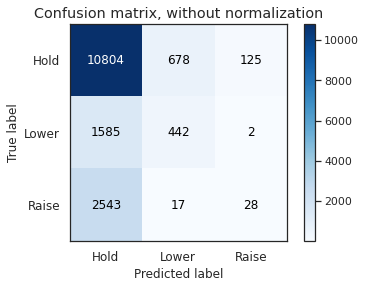

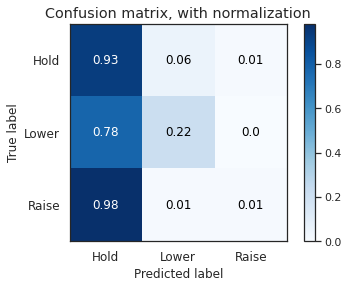

Epoch: 1/3... Step: 2850... Loss: 0.740072... Val Loss: 0.557221 Accuracy: 0.750000 F1 Score: 0.285714
Epoch: 1/3... Step: 2850... Loss: 0.740072... Val Loss: 0.525714 Accuracy: 0.781250 F1 Score: 0.424242
Epoch: 1/3... Step: 2850... Loss: 0.740072... Val Loss: 0.662445 Accuracy: 0.708333 F1 Score: 0.370238
Epoch: 1/3... Step: 2850... Loss: 0.740072... Val Loss: 0.787968 Accuracy: 0.656250 F1 Score: 0.329487
Epoch: 1/3... Step: 2850... Loss: 0.740072... Val Loss: 0.797095 Accuracy: 0.637500 F1 Score: 0.340551
Epoch: 1/3... Step: 2850... Loss: 0.740072... Val Loss: 0.785732 Accuracy: 0.635417 F1 Score: 0.370976
Epoch: 1/3... Step: 2850... Loss: 0.740072... Val Loss: 0.801687 Accuracy: 0.625000 F1 Score: 0.355438
Epoch: 1/3... Step: 2850... Loss: 0.740072... Val Loss: 0.836018 Accuracy: 0.617188 F1 Score: 0.346494
Epoch: 1/3... Step: 2850... Loss: 0.740072... Val Loss: 0.840712 Accuracy: 0.618056 F1 Score: 0.335185
Epoch: 1/3... Step: 2850... Loss: 0.740072... Val Loss: 0.841383 Accuracy

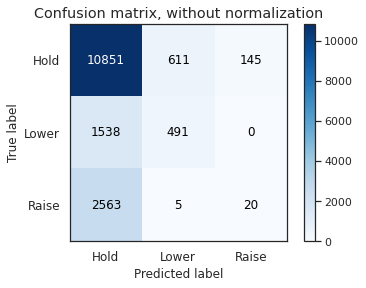

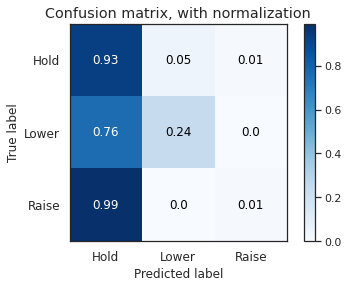

Epoch: 1/3... Step: 3800... Loss: 1.043609... Val Loss: 0.572012 Accuracy: 0.750000 F1 Score: 0.285714
Epoch: 1/3... Step: 3800... Loss: 1.043609... Val Loss: 0.523082 Accuracy: 0.750000 F1 Score: 0.285714
Epoch: 1/3... Step: 3800... Loss: 1.043609... Val Loss: 0.648284 Accuracy: 0.687500 F1 Score: 0.271605
Epoch: 1/3... Step: 3800... Loss: 1.043609... Val Loss: 0.726655 Accuracy: 0.656250 F1 Score: 0.264151
Epoch: 1/3... Step: 3800... Loss: 1.043609... Val Loss: 0.745433 Accuracy: 0.637500 F1 Score: 0.306017
Epoch: 1/3... Step: 3800... Loss: 1.043609... Val Loss: 0.727269 Accuracy: 0.656250 F1 Score: 0.367258
Epoch: 1/3... Step: 3800... Loss: 1.043609... Val Loss: 0.748200 Accuracy: 0.642857 F1 Score: 0.374126
Epoch: 1/3... Step: 3800... Loss: 1.043609... Val Loss: 0.791206 Accuracy: 0.632812 F1 Score: 0.378344
Epoch: 1/3... Step: 3800... Loss: 1.043609... Val Loss: 0.791214 Accuracy: 0.631944 F1 Score: 0.364339
Epoch: 1/3... Step: 3800... Loss: 1.043609... Val Loss: 0.793077 Accuracy

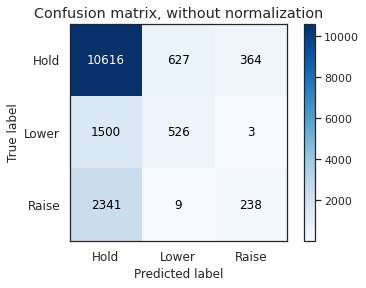

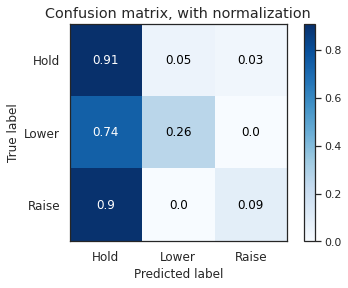

Starting epoch 2
Epoch: 2/3... Step: 950... Loss: 0.458582... Val Loss: 0.567582 Accuracy: 0.812500 F1 Score: 0.298851
Epoch: 2/3... Step: 950... Loss: 0.458582... Val Loss: 0.492482 Accuracy: 0.843750 F1 Score: 0.470760
Epoch: 2/3... Step: 950... Loss: 0.458582... Val Loss: 0.579242 Accuracy: 0.770833 F1 Score: 0.478542
Epoch: 2/3... Step: 950... Loss: 0.458582... Val Loss: 0.671430 Accuracy: 0.718750 F1 Score: 0.424878
Epoch: 2/3... Step: 950... Loss: 0.458582... Val Loss: 0.715996 Accuracy: 0.687500 F1 Score: 0.431932
Epoch: 2/3... Step: 950... Loss: 0.458582... Val Loss: 0.712971 Accuracy: 0.687500 F1 Score: 0.436299
Epoch: 2/3... Step: 950... Loss: 0.458582... Val Loss: 0.718249 Accuracy: 0.678571 F1 Score: 0.434427
Epoch: 2/3... Step: 950... Loss: 0.458582... Val Loss: 0.776216 Accuracy: 0.656250 F1 Score: 0.407009
Epoch: 2/3... Step: 950... Loss: 0.458582... Val Loss: 0.764178 Accuracy: 0.659722 F1 Score: 0.395001
Epoch: 2/3... Step: 950... Loss: 0.458582... Val Loss: 0.775087 A

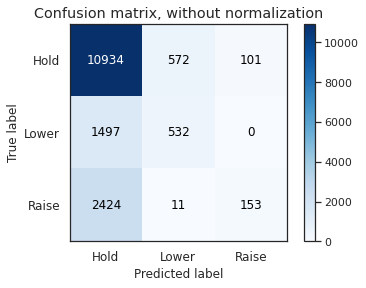

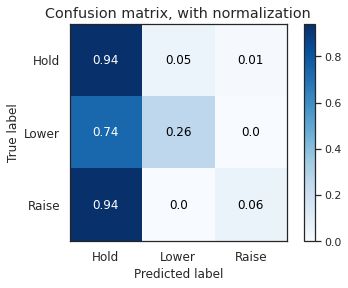

Epoch: 2/3... Step: 1900... Loss: 0.700006... Val Loss: 0.536129 Accuracy: 0.812500 F1 Score: 0.298851
Epoch: 2/3... Step: 1900... Loss: 0.700006... Val Loss: 0.525168 Accuracy: 0.781250 F1 Score: 0.292398
Epoch: 2/3... Step: 1900... Loss: 0.700006... Val Loss: 0.659106 Accuracy: 0.729167 F1 Score: 0.363169
Epoch: 2/3... Step: 1900... Loss: 0.700006... Val Loss: 0.731943 Accuracy: 0.687500 F1 Score: 0.390443
Epoch: 2/3... Step: 1900... Loss: 0.700006... Val Loss: 0.755942 Accuracy: 0.662500 F1 Score: 0.380114
Epoch: 2/3... Step: 1900... Loss: 0.700006... Val Loss: 0.758975 Accuracy: 0.666667 F1 Score: 0.396491
Epoch: 2/3... Step: 1900... Loss: 0.700006... Val Loss: 0.755940 Accuracy: 0.660714 F1 Score: 0.397016
Epoch: 2/3... Step: 1900... Loss: 0.700006... Val Loss: 0.798227 Accuracy: 0.656250 F1 Score: 0.404742
Epoch: 2/3... Step: 1900... Loss: 0.700006... Val Loss: 0.787523 Accuracy: 0.652778 F1 Score: 0.388619
Epoch: 2/3... Step: 1900... Loss: 0.700006... Val Loss: 0.786162 Accuracy

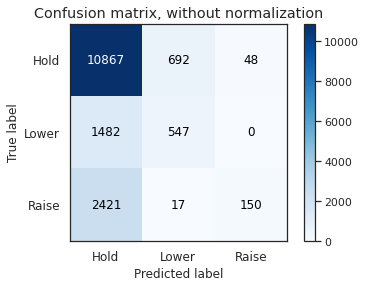

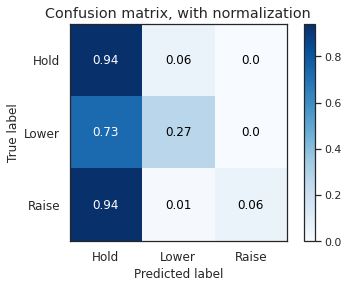

Epoch: 2/3... Step: 2850... Loss: 0.758387... Val Loss: 0.492124 Accuracy: 0.812500 F1 Score: 0.298851
Epoch: 2/3... Step: 2850... Loss: 0.758387... Val Loss: 0.497448 Accuracy: 0.781250 F1 Score: 0.292398
Epoch: 2/3... Step: 2850... Loss: 0.758387... Val Loss: 0.596245 Accuracy: 0.708333 F1 Score: 0.276423
Epoch: 2/3... Step: 2850... Loss: 0.758387... Val Loss: 0.692737 Accuracy: 0.671875 F1 Score: 0.333333
Epoch: 2/3... Step: 2850... Loss: 0.758387... Val Loss: 0.735184 Accuracy: 0.650000 F1 Score: 0.343750
Epoch: 2/3... Step: 2850... Loss: 0.758387... Val Loss: 0.740840 Accuracy: 0.645833 F1 Score: 0.358772
Epoch: 2/3... Step: 2850... Loss: 0.758387... Val Loss: 0.748758 Accuracy: 0.651786 F1 Score: 0.374621
Epoch: 2/3... Step: 2850... Loss: 0.758387... Val Loss: 0.786903 Accuracy: 0.640625 F1 Score: 0.360414
Epoch: 2/3... Step: 2850... Loss: 0.758387... Val Loss: 0.782796 Accuracy: 0.645833 F1 Score: 0.352031
Epoch: 2/3... Step: 2850... Loss: 0.758387... Val Loss: 0.792177 Accuracy

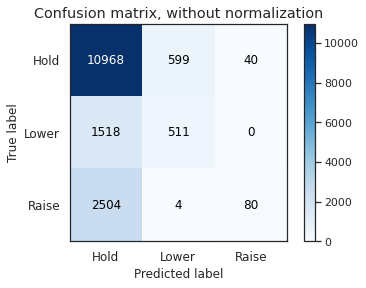

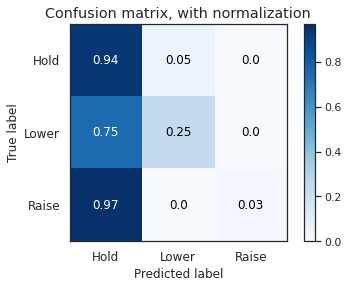

Epoch: 2/3... Step: 3800... Loss: 1.099310... Val Loss: 0.513551 Accuracy: 0.812500 F1 Score: 0.298851
Epoch: 2/3... Step: 3800... Loss: 1.099310... Val Loss: 0.523862 Accuracy: 0.843750 F1 Score: 0.470760
Epoch: 2/3... Step: 3800... Loss: 1.099310... Val Loss: 0.595527 Accuracy: 0.729167 F1 Score: 0.346502
Epoch: 2/3... Step: 3800... Loss: 1.099310... Val Loss: 0.668245 Accuracy: 0.671875 F1 Score: 0.308333
Epoch: 2/3... Step: 3800... Loss: 1.099310... Val Loss: 0.705840 Accuracy: 0.637500 F1 Score: 0.323885
Epoch: 2/3... Step: 3800... Loss: 1.099310... Val Loss: 0.694235 Accuracy: 0.656250 F1 Score: 0.383035
Epoch: 2/3... Step: 3800... Loss: 1.099310... Val Loss: 0.715126 Accuracy: 0.651786 F1 Score: 0.393968
Epoch: 2/3... Step: 3800... Loss: 1.099310... Val Loss: 0.756296 Accuracy: 0.648438 F1 Score: 0.394359
Epoch: 2/3... Step: 3800... Loss: 1.099310... Val Loss: 0.743412 Accuracy: 0.659722 F1 Score: 0.402113
Epoch: 2/3... Step: 3800... Loss: 1.099310... Val Loss: 0.748523 Accuracy

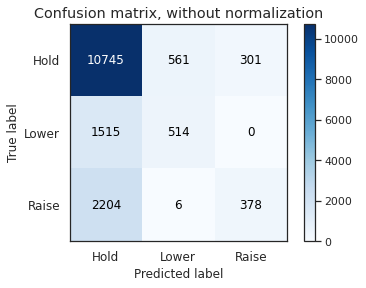

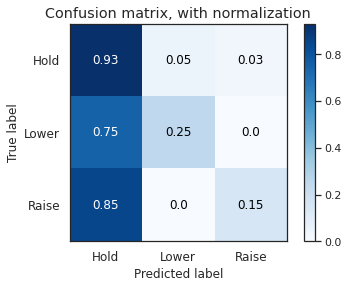

Starting epoch 3
Epoch: 3/3... Step: 950... Loss: 0.423193... Val Loss: 0.528970 Accuracy: 0.812500 F1 Score: 0.298851
Epoch: 3/3... Step: 950... Loss: 0.423193... Val Loss: 0.546710 Accuracy: 0.812500 F1 Score: 0.298851
Epoch: 3/3... Step: 950... Loss: 0.423193... Val Loss: 0.635150 Accuracy: 0.729167 F1 Score: 0.281124
Epoch: 3/3... Step: 950... Loss: 0.423193... Val Loss: 0.706956 Accuracy: 0.671875 F1 Score: 0.267913
Epoch: 3/3... Step: 950... Loss: 0.423193... Val Loss: 0.722561 Accuracy: 0.675000 F1 Score: 0.355952
Epoch: 3/3... Step: 950... Loss: 0.423193... Val Loss: 0.708753 Accuracy: 0.677083 F1 Score: 0.372549
Epoch: 3/3... Step: 950... Loss: 0.423193... Val Loss: 0.711696 Accuracy: 0.669643 F1 Score: 0.356498
Epoch: 3/3... Step: 950... Loss: 0.423193... Val Loss: 0.749827 Accuracy: 0.656250 F1 Score: 0.359389
Epoch: 3/3... Step: 950... Loss: 0.423193... Val Loss: 0.735144 Accuracy: 0.666667 F1 Score: 0.372742
Epoch: 3/3... Step: 950... Loss: 0.423193... Val Loss: 0.744791 A

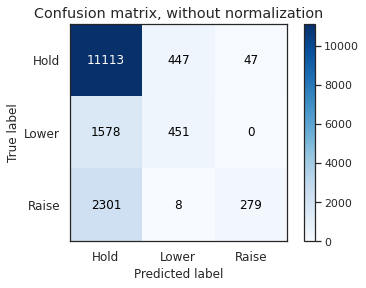

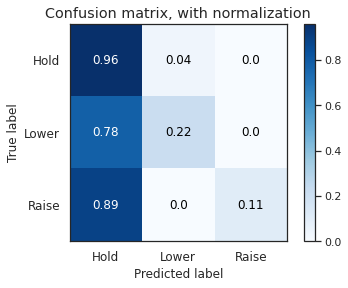

Epoch: 3/3... Step: 1900... Loss: 0.702901... Val Loss: 0.496461 Accuracy: 0.812500 F1 Score: 0.298851
Epoch: 3/3... Step: 1900... Loss: 0.702901... Val Loss: 0.484712 Accuracy: 0.781250 F1 Score: 0.292398
Epoch: 3/3... Step: 1900... Loss: 0.702901... Val Loss: 0.612888 Accuracy: 0.708333 F1 Score: 0.276423
Epoch: 3/3... Step: 1900... Loss: 0.702901... Val Loss: 0.720981 Accuracy: 0.656250 F1 Score: 0.264151
Epoch: 3/3... Step: 1900... Loss: 0.702901... Val Loss: 0.710088 Accuracy: 0.650000 F1 Score: 0.305983
Epoch: 3/3... Step: 1900... Loss: 0.702901... Val Loss: 0.707597 Accuracy: 0.645833 F1 Score: 0.329916
Epoch: 3/3... Step: 1900... Loss: 0.702901... Val Loss: 0.725236 Accuracy: 0.633929 F1 Score: 0.316272
Epoch: 3/3... Step: 1900... Loss: 0.702901... Val Loss: 0.751913 Accuracy: 0.625000 F1 Score: 0.306260
Epoch: 3/3... Step: 1900... Loss: 0.702901... Val Loss: 0.748729 Accuracy: 0.631944 F1 Score: 0.303652
Epoch: 3/3... Step: 1900... Loss: 0.702901... Val Loss: 0.755639 Accuracy

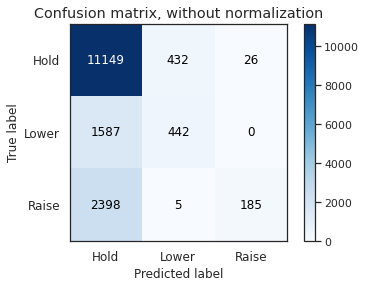

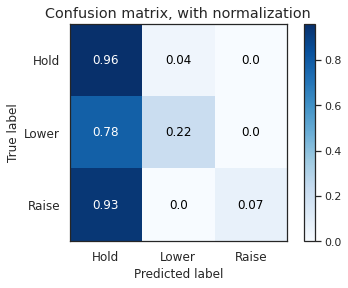

Epoch: 3/3... Step: 2850... Loss: 0.766235... Val Loss: 0.454367 Accuracy: 0.812500 F1 Score: 0.298851
Epoch: 3/3... Step: 2850... Loss: 0.766235... Val Loss: 0.487478 Accuracy: 0.781250 F1 Score: 0.292398
Epoch: 3/3... Step: 2850... Loss: 0.766235... Val Loss: 0.579687 Accuracy: 0.708333 F1 Score: 0.276423
Epoch: 3/3... Step: 2850... Loss: 0.766235... Val Loss: 0.671010 Accuracy: 0.656250 F1 Score: 0.264151
Epoch: 3/3... Step: 2850... Loss: 0.766235... Val Loss: 0.709889 Accuracy: 0.637500 F1 Score: 0.338100
Epoch: 3/3... Step: 2850... Loss: 0.766235... Val Loss: 0.713686 Accuracy: 0.625000 F1 Score: 0.350303
Epoch: 3/3... Step: 2850... Loss: 0.766235... Val Loss: 0.705959 Accuracy: 0.633929 F1 Score: 0.364127
Epoch: 3/3... Step: 2850... Loss: 0.766235... Val Loss: 0.736554 Accuracy: 0.625000 F1 Score: 0.348693
Epoch: 3/3... Step: 2850... Loss: 0.766235... Val Loss: 0.725986 Accuracy: 0.631944 F1 Score: 0.342962
Epoch: 3/3... Step: 2850... Loss: 0.766235... Val Loss: 0.733430 Accuracy

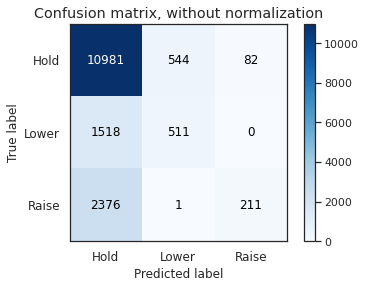

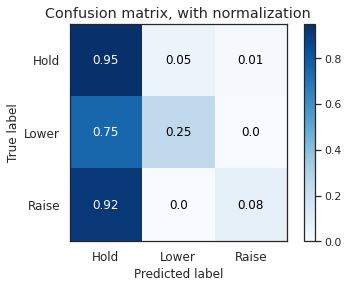

Epoch: 3/3... Step: 3800... Loss: 0.889019... Val Loss: 0.492515 Accuracy: 0.812500 F1 Score: 0.298851
Epoch: 3/3... Step: 3800... Loss: 0.889019... Val Loss: 0.510168 Accuracy: 0.812500 F1 Score: 0.464286
Epoch: 3/3... Step: 3800... Loss: 0.889019... Val Loss: 0.565996 Accuracy: 0.708333 F1 Score: 0.349074
Epoch: 3/3... Step: 3800... Loss: 0.889019... Val Loss: 0.648724 Accuracy: 0.687500 F1 Score: 0.383516
Epoch: 3/3... Step: 3800... Loss: 0.889019... Val Loss: 0.686916 Accuracy: 0.662500 F1 Score: 0.380262
Epoch: 3/3... Step: 3800... Loss: 0.889019... Val Loss: 0.676712 Accuracy: 0.656250 F1 Score: 0.383035
Epoch: 3/3... Step: 3800... Loss: 0.889019... Val Loss: 0.683598 Accuracy: 0.651786 F1 Score: 0.394680
Epoch: 3/3... Step: 3800... Loss: 0.889019... Val Loss: 0.709721 Accuracy: 0.640625 F1 Score: 0.390572
Epoch: 3/3... Step: 3800... Loss: 0.889019... Val Loss: 0.704644 Accuracy: 0.652778 F1 Score: 0.397732
Epoch: 3/3... Step: 3800... Loss: 0.889019... Val Loss: 0.708015 Accuracy

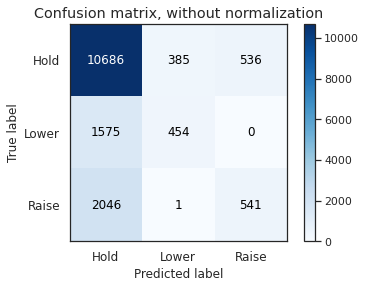

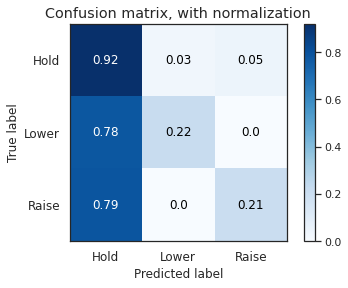

In [112]:
train_model(model, epochs=3, batch_size=16, learning_rate=1e-4, sequence_length=200, clip=5, print_every=950) #TODO: change print_every to get graphs

## E. BERT Model

In [113]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
#import torch


In [114]:
class InputFeature(object):
    def __init__(self, id, input_ids, masks, segments, meta, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments,
            'meta': meta
        }
        self.label = label

In [115]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=200):
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

In [ ]:
train_set = []
max_seq_length = 200
meta_size = 10

for index, row in tqdm(split_train_df.iterrows(), total=split_train_df.shape[0]):
    input_ids, masks, segments = bert_encoder(row['text'], max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, row[nontext_columns + ['tone']], int(row['target'])))    

train_labels = split_train_df['target'].astype(int).values
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_meta =np.array([data.features['meta'] for data in train_set], dtype=np.float64)
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(split_train_df), 3), dtype=np.float32)

In [ ]:
print(train_valid_meta[0])
print(train_valid_meta[1])

In [ ]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, meta_size, output_size, dropout=0.1):
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, nn_input_meta):
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        # print(len(dense_out[0]))
        # print(len(nn_input_meta[0]))
        # print(len(concat_layer[0]))
        # print("dense_out: \n", dense_out)
        # print("nn_input_meta: \n", nn_input_meta)
        # print("concat_layer: \n", concat_layer)
        out = self.fc2(concat_layer)
        #logps = self.softmax(out)

        return out

In [ ]:
# Check how BertTokenizer works
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

print(input_ids)
print(outputs) # The last hidden-state is the first element of the output tuple


In [ ]:
# Test Tokenizer - Own Implementation
bert_model = BertTextClassifier(768, 128, meta_size, 3, dropout=0.1)

text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
print('text_ids: \n', text_ids)
print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
text_ids = torch.tensor(text_ids).unsqueeze(0)
print('text_ids (unsqueezed): \n', text_ids)
#print('pad_masks: ',pad_masks)
#print('segment_ids: ',segment_ids)
x_meta = torch.tensor([1,2,3,4,5,6,7,8,9,10]).unsqueeze(0)
outputs = bert_model(text_ids, x_meta)
print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs.detach())

In [ ]:
# Hyperparameters
learning_rate = 1e-5
num_epochs = 3
batch_size = 32
patience =2
file_name = 'model'
use_skf = True
bert_hidden_size = 768
bert_dense_size =128

In [ ]:
def train_bert(fold, train_indices, valid_indices):
    
    # Number of folds to iterrate
    # if fold == 3:
    #     break

    logger.info('================     fold {}        ==============='.format(fold))
    
    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    train_meta = torch.tensor(train_valid_meta[train_indices], dtype=torch.long)
    
    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)
    valid_meta = torch.tensor(train_valid_meta[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_meta, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_meta, valid_label)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
#     bert_model = BertForSequenceClassification.from_pretrained(
#         "bert-base-uncased",
#         num_labels = 3,
#         output_attentions = False,
#         output_hidden_states = False
#     )

    bert_model = BertTextClassifier(bert_hidden_size, bert_dense_size, meta_size, 3, dropout=0.1)
    
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    bert_model = bert_model.to(device)
    
    # Loss Function - use Cross Entropy as binary classification
    loss_fn = torch.nn.CrossEntropyLoss()

    # Optimizer - Adam with parameter groups
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)
    
    # Set Train Mode
    bert_model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}        ==============='.format(epoch+1))
        train_loss = 0.
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)
            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, x_meta, y_truth = batch
            
            # Feedforward prediction
            y_pred = bert_model(x_ids, x_meta)

            # Calculate Loss
            loss = loss_fn(y_pred, y_truth)
                        
            # Reset gradient
            optimizer.zero_grad()
            # Backward Propagation
            loss.backward()
            # Update Weights
            optimizer.step()
            # Training Loss
            train_loss += loss.item() / len(train_loader)
            
            logger.debug('train batch: %d, train_loss: %8f\n' % (i, train_loss))

        train_losses.append(train_loss)
        # Move to Evaluation Mode
        model.eval()
        
        # Initialize
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, x_meta, y_truth = batch
                y_pred = bert_model(x_ids, x_meta).detach()
                loss = loss_fn(y_pred, y_truth)
                val_loss += loss.item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()
                
                logger.debug('validation batch: {}, val_loss: {}, valid_preds_fold: {}'.format(i, val_loss, valid_preds_fold[i * batch_size:(i + 1) * batch_size]))
            valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(bert_model.state_dict(), output_dir + 'model_fold_{}.dict'.format(fold))
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.8f, f1: %.8f, best_f1: %.8f\n' %
            (epoch, train_loss, val_loss, acc, f1, best_f1))
        
        if device == 'cuda:0':
            torch.cuda.empty_cache()  

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break
            
        model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 3))
    
    # Draw training/validation losses
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (15,6)
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'b-o')

    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.show()

    # Load the best model
    bert_model.load_state_dict(torch.load(output_dir + 'model_fold_{}.dict'.format(fold)))
    # Set Evaluation Mode
    bert_model.eval()
    
    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, x_meta, y_truth = batch
            y_pred = bert_model(x_ids, x_meta).detach()
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()

    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    class_names = ['Lower', 'Hold', 'Raise']
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1), normalize=normalize, title=title)
    plt.show()

In [ ]:
if use_skf:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  
    for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
        train_bert(fold, train_indices, valid_indices)

else:
    train_ratio = 0.7
    train_indices = np.arange(0, int(len(train_valid_labels)*train_ratio))
    valid_indices = np.arange(int(len(train_valid_labels)*train_ratio), len(train_valid_labels))

    train_bert(0, train_indices, valid_indices)
    # print('train_indices', train_indices)
    # print('valid_indices', valid_indices)


In [ ]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))
split_train_df['pred_target'] = np.argmax(oof_train, axis=1)
split_train_df['pred_target_lower'] = oof_train[:,0]
split_train_df['pred_target_hold'] = oof_train[:,1]
split_train_df['pred_target_raise'] = oof_train[:,2]
split_train_df.head()

# Save Data

In [ ]:
def save_data(df, file_name, dir_name=train_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save text data
save_data(train_df, 'train_df')
save_data(text_df, 'text_df')
save_data(train_df, 'split_train_df')